# EECE5644 Final Project
## Image Classification of Mars Curiosity Rover 
### Ethan Holand and Jarrod Homer
***

In [78]:
import matplotlib.pyplot as plt # For general plotting

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold # Important new include

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.transforms as transforms

# Utility to visualize PyTorch network and shapes
from torchsummary import summary

# from torchsampler import ImbalancedDatasetSampler

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
random_seed = 7
np.random.seed(random_seed)
torch.manual_seed(random_seed)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

In [79]:
# Sets code to run on cpu or gpu, depending on what is available:
# In testing, GPU accel improves performance tenfold
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23]), array([  51,   16,   29,  105,   31,   29,   51,  126, 2077,  237,  145,
         21,   71,   54,  119,   78,   53,   66,    8,   38,   57,  141,
        142,  295]))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23]), array([ 13,   4,   7,  26,   8,   7,  13,  32, 520,  59,  36,   5,  18,
        14,  30,  19,  13,  16,   2,  10,  14,  35,  36,  74]))
turret inlet ground scoop wheel ground ground ground


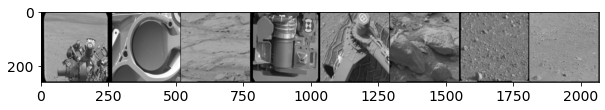

In [80]:
# Define how transform the data for processing in batches
transform = transforms.Compose([
        transforms.Resize([256,256]), # Resizing the image
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.0,0.0,0.0), std=(1.0,1.0,1.0)),
        transforms.Grayscale() # Converting images to grayscale, helps with hyperspectral
    ])

# Specify the batch size for SGD
batch_size = 64
# Use the ImageFolder class, which is a generic dataloder useful when images stored in labelled directories
# Apply transform to images specified above, importantly converting "ToTensor"
# test_dataset= torchvision.datasets.ImageFolder(root=r'C:\Users\ethan\OneDrive - Northeastern University\_Summer 2022\EECE5644 Machine Learning\EECE5644\Project\rearrangedFiles\test', transform=transform)
# train_dataset = torchvision.datasets.ImageFolder(root=r'C:\Users\ethan\OneDrive - Northeastern University\_Summer 2022\EECE5644 Machine Learning\EECE5644\Project\rearrangedFiles\train', transform=transform)
# print("Dataset has {} training samples and {} test samples".format(len(train_dataset), len(test_dataset)))

dataset = torchvision.datasets.ImageFolder(root=r'~/Downloads/EECE5644/Project/rearrangedFiles/train', transform=transform)
# valid_dataset = torchvision.datasets.ImageFolder(root=r'C:\Users\ethan\OneDrive - Northeastern University\_Summer 2022\EECE5644 Machine Learning\EECE5644\Project\rearrangedFiles\valid', transform=transform)


# Specify classes for convenience in printing
classes = ('apxs', 'apxs cal target', 'chemcam cal target', 'chemin inlet open', 'drill', 'drill holes', 'drt front', 'drt side', 'ground', 'horizon', 'inlet', 'mahli', 'mahli cal target', 'mastcam', 'mastcam cal target', 'observation tray', 'portion box', 'portion tube', 'portion tube opening', 'rems uv sensor', 'rover rear deck', 'scoop', 'turret', 'wheel')

# List of targets/labels for entire dataset
targets = dataset.targets
# Use sklearn function to split the data into training-test sets (80-20 split)
# Stratified ensures that same percentage of samples of each target class form a complete set
train_idx, test_idx= train_test_split(
    np.arange(len(targets)), test_size=0.2, random_state=random_seed, shuffle=True, stratify=targets)

# Printing the unique class labels in each split set and the number of occurrences per class
print(np.unique(np.array(targets)[train_idx], return_counts=True))
print(np.unique(np.array(targets)[test_idx], return_counts=True))

# Create training and test subsets based on split indices
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

# Define iterable for our newly created dataset and shuffle samples 
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
# valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)


### Plotting stuff ###
fig = plt.figure(figsize=(10,15))
# Utility function to show an image
def imshow(img):
    img_np = img.numpy()
    plt.imshow(np.transpose(img_np, (1, 2, 0)))

# Get some random training dataset images
dataiter = iter(train_dataloader)
# Extract a batch
images, labels = dataiter.next()
# Show images
imshow(torchvision.utils.make_grid(images[:8]))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [81]:
# Code to find class weights. This could help the imbalanced dataset, but testing has shown otherwise
class_weights=class_weight.compute_class_weight(class_weight='balanced',classes = np.unique(dataset.targets),y=dataset.targets)
class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)
print(class_weights)

tensor([ 3.2884, 10.5229,  5.8461,  1.6066,  5.3964,  5.8461,  3.2884,  1.3320,
         0.0810,  0.7110,  1.1628,  8.0946,  2.3647,  3.0950,  1.4125,  2.1697,
         3.1888,  2.5666, 21.0458,  4.3845,  2.9642,  1.1958,  1.1824,  0.5703],
       device='cuda:0')


In [82]:
# Note that PyTorch uses NCHW (samples, channels, height, width) image format convention
class ConvNet(nn.Module):
    def __init__(self, in_channels, num_filters, out_classes, kernel_size=3):
        super().__init__()
        # Conv2D layer with 'same' padding so image retains shape
        self.conv1 = nn.Conv2d(in_channels, num_filters, kernel_size, padding='same')
        self.drop = nn.Dropout(p=0.2)
        #self.dropout = 
        # MaxPooling layer with 2x2 kernel size and stride 2
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(num_filters, num_filters*2, kernel_size, padding='same')
        self.fc1 = nn.Linear(num_filters*2*64*64, num_filters)
        self.fc2 = nn.Linear(num_filters, out_classes)

    def forward(self, x):
        x = x.to(device)
        # Non-linear ReLU activations between convolutional layers
        # Conv->ReLU->Pooling
        # 280x280 image -> 140x140 after pooling
        x = self.pool(self.drop(F.relu(self.conv1(x))))
        # 140x140 feature map -> 70x70 after pooling
        x = self.pool(self.drop(F.relu(self.conv2(x))))
        # Flatten all dimensions except batch (start_dim=1)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [83]:
def model_train_loader(model, dataloader, criterion, optimizer):
    size = len(dataloader.dataset)

    model.train().to(device)
    for batch, (X, y) in enumerate(dataloader):
        X=X.to(device)
        y = y.to(device)
        # Compute prediction error
        predictions = model(X).to(device)
        loss = criterion(predictions, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Report loss every 10 batches
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
            
def model_test_loader(model, dataloader, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Tracking test loss (cross-entropy) and correct classification rate (accuracy)
    test_loss, correct = 0, 0
    
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X=X.to(device)
            y=y.to(device)
            predictions = model(X).to(device)
            test_loss += criterion(predictions, y)
            correct += (predictions.argmax(1) == y).type(torch.float).sum()
            
    test_loss /= num_batches
    correct /= size
    accuracy = 100*correct
    print(f"Test Error: \n Accuracy: {(accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return accuracy




CV Running:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             160
           Dropout-2         [-1, 16, 256, 256]               0
         MaxPool2d-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           4,640
           Dropout-5         [-1, 32, 128, 128]               0
         MaxPool2d-6           [-1, 32, 64, 64]               0
            Linear-7                   [-1, 16]       2,097,168
            Linear-8                   [-1, 24]             408
Total params: 2,102,376
Trainable params: 2,102,376
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 27.00
Params size (MB): 8.02
Estimated Total Size (MB): 35.27
----------------------------------------------------------------
Epoch 1
---------------

TypeError: len() takes exactly one argument (0 given)

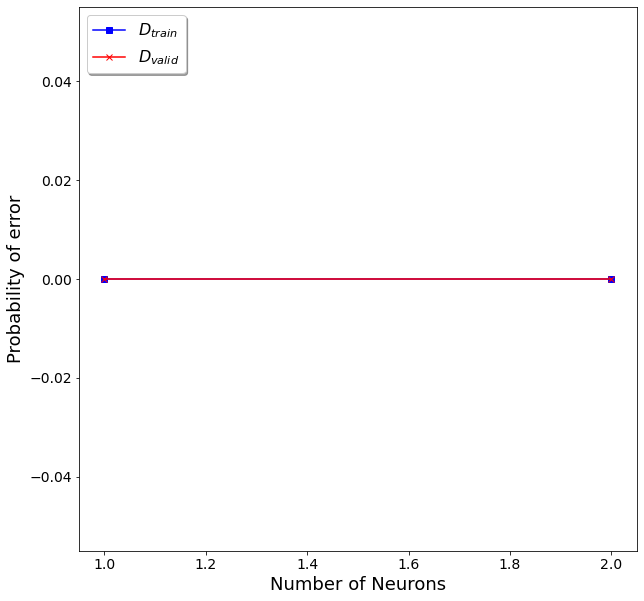

In [84]:

print("\nCV Running:")
#########################################################   Do CV
nerons = [1,2]
n_nerons= len(nerons)


# Number of folds for CV
K = 10

# STEP 1: Partition the dataset into K approximately-equal-sized partitions
# Shuffles data before doing the division into folds (not necessary, but a good idea)
kf = KFold(n_splits=K, shuffle=True) 

# Allocate space for CV
# No need for training loss storage too but useful comparison
mse_valid_mk = np.empty((n_nerons, K)) 
mse_train_mk = np.empty((n_nerons, K)) # Indexed by model m, data partition k

# STEP 2: Try all polynomial orders between 1 (best line fit) and 21 (big time overfit) M=2
nerind=0
for ner in nerons:
    # K-fold cross validation
    k = 0
    # NOTE that these subsets are of the TRAINING dataset
    # Imagine we don't have enough data available to afford another entirely separate validation set
    for train_indices, valid_indices in kf.split(train_dataset):
        # Extract the training and validation sets from the K-fold split


        # Create training and test subsets based on split indices
        cv_train_dataset = Subset(dataset, train_indices)
        cv_test_dataset = Subset(dataset, valid_indices)

        # Define iterable for our newly created dataset and shuffle samples 
        cv_train_dataloader = DataLoader(cv_train_dataset, batch_size=batch_size, shuffle=True)
        cv_test_dataloader = DataLoader(cv_test_dataset, batch_size=batch_size)
        # valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
        

        ############Do model stuff
        input_channels = images.shape[1]
        model = ConvNet(input_channels, num_filters=16, out_classes=len(classes)).to(device)
        summary(model, input_size=(input_channels, 256, 256))
        # The nn.CrossEntropyLoss() loss function automatically performs a log_softmax() to output
        criterion = nn.CrossEntropyLoss() #(weight=class_weights)
        num_epochs = 2
        accuracies = np.zeros(num_epochs)


        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
        for t in range(num_epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            model_train_loader(model, cv_train_dataloader, criterion, optimizer)
            accuracies[t] = model_test_loader(model, cv_test_dataloader, criterion)

        ###########finish trianing stuff


        

        # Validation fold polynomial transformation

        # validation set:
        model_test_loader(model, cv_test_dataloader, criterion)
        


        k += 1

    nerind+=1
            
# STEP 3: Compute the average MSE loss for that model (based in this case on degree d)
mse_train_m = np.mean(mse_train_mk, axis=1) # Model average CV loss over folds
mse_valid_m = np.mean(mse_valid_mk, axis=1) 

# Plot MSE vs degree
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(nerons, mse_train_m, color="b", marker="s", label=r"$D_{train}$")
ax.plot(nerons, mse_valid_m, color="r", marker="x", label=r"$D_{valid}$")


ax.legend(loc='upper left', shadow=True)
plt.xlabel("Number of Neurons")
plt.ylabel("Probability of error")
plt.title("Probabilities of error with 5-fold cross-validation for "+str(len())+" samples")
plt.show()






# Plot accuracies over epochs:
fig = plt.figure(figsize=(10, 10))
plt.plot(range(num_epochs), accuracies)
plt.title("Accuracy vs epochs for # epochs = {}".format(num_epochs))
plt.legend()
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('%Accuracy')
plt.show()

In [ ]:
# validation set:
model_test_loader(model, test_dataloader, criterion)

Test Error: 
 Accuracy: 71.6%, Avg loss: 1.041646 



tensor(71.6123, device='cuda:0')

GroundTruth:  wheel drt side ground ground observation tray drt side ground ground ground ground horizon portion tube ground wheel wheel ground chemcam cal target inlet horizon ground ground ground rems uv sensor ground ground horizon horizon scoop scoop ground ground inlet ground wheel ground ground drt side ground drt side apxs  ground mastcam ground ground ground ground ground ground ground ground inlet ground wheel horizon ground ground ground ground portion tube ground ground drt front ground ground
Predicted:  wheel drt side ground ground portion tube ground ground ground ground ground ground portion tube ground ground wheel ground wheel ground ground ground ground ground mastcam ground ground ground ground inlet scoop ground ground inlet ground wheel ground ground ground ground drt side turret ground ground ground ground ground ground ground ground ground ground inlet ground wheel ground ground ground ground ground portion tube ground ground wheel ground ground


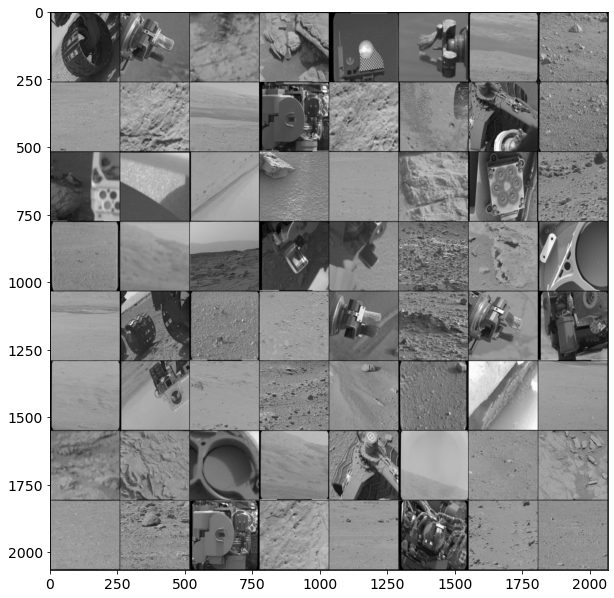

In [ ]:
### Plotting stuff ###
fig = plt.figure(figsize=(10,15))

# Get some random test dataset images
dataiter = iter(test_dataloader)
# Extract a batch
images, labels = dataiter.next()
# Show images
imshow(torchvision.utils.make_grid(images[:64]))
# Print labels
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(64)))

outputs = model(images).to(device)
# Argmax take the most probable class
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(64)))

tensor([23,  7,  8,  8, 15,  7,  8,  8,  8,  8,  9, 17,  8, 23, 23,  8,  2, 10,
         9,  8,  8,  8, 19,  8,  8,  9,  9, 21, 21,  8,  8, 10,  8, 23,  8,  8,
         7,  8,  7,  0,  8, 13,  8,  8,  8,  8,  8,  8,  8,  8, 10,  8, 23,  9,
         8,  8,  8,  8, 17,  8,  8,  6,  8,  8])


<AxesSubplot:>

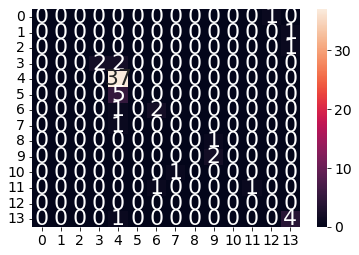

In [ ]:
print(labels)

cf_matrix = confusion_matrix(labels.to('cpu'), predicted.to('cpu'))
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)